In [270]:
import pandas as pd
import sqlite3
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (train_test_split,
                                     StratifiedKFold, cross_val_score, GridSearchCV)
from sklearn.preprocessing import StandardScaler, OneHotEncoder , RobustScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_score, recall_score)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier as xgb_c
from sklearn.preprocessing import LabelEncoder

# 1. Configuración visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# 2. Definir ruta y conectar
db_path = os.path.join('..', 'sql', 'heart_failure.db')

try:
    conn = sqlite3.connect(db_path)
    print(f"✅ Conexión establecida con éxito a: {db_path}")
except Exception as e:
    print(f"❌ Error de conexión: {e}")

# 3. Query de prueba
query_prueba = "SELECT * FROM pacientes LIMIT 5"
df_check = pd.read_sql_query(query_prueba, conn)

# 4. Mostrar
df_check.head()

✅ Conexión establecida con éxito a: ..\sql\heart_failure.db


,edad,anemia,cpk,diabetes,fraccion_eyeccion,presion_alta,plaquetas,creatinina_serica,sodio_serico,sexo,fumador,dias_seguimiento,muerte
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


# EDA

In [271]:
# 1. Definimos la query para traer TODO el contenido de la tabla
query = "SELECT * FROM pacientes"

# 2. Ejecutamos la query y lo guardamos en la variable 'df'
df = pd.read_sql_query(query, conn)

# 3. Verificamos las dimensiones
# Deberías ver (299, 13) si todo salió bien
print(f"Dimensiones del dataset: {df.shape}")

# 4. Mostramos las primeras filas para confirmar
df.head()

Dimensiones del dataset: (299, 13)


,edad,anemia,cpk,diabetes,fraccion_eyeccion,presion_alta,plaquetas,creatinina_serica,sodio_serico,sexo,fumador,dias_seguimiento,muerte
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [272]:
df["muerte"].value_counts()

muerte
0    203
1     96
Name: count, dtype: int64

In [273]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   edad               299 non-null    float64
 1   anemia             299 non-null    int64  
 2   cpk                299 non-null    int64  
 3   diabetes           299 non-null    int64  
 4   fraccion_eyeccion  299 non-null    int64  
 5   presion_alta       299 non-null    int64  
 6   plaquetas          299 non-null    float64
 7   creatinina_serica  299 non-null    float64
 8   sodio_serico       299 non-null    int64  
 9   sexo               299 non-null    int64  
 10  fumador            299 non-null    int64  
 11  dias_seguimiento   299 non-null    int64  
 12  muerte             299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


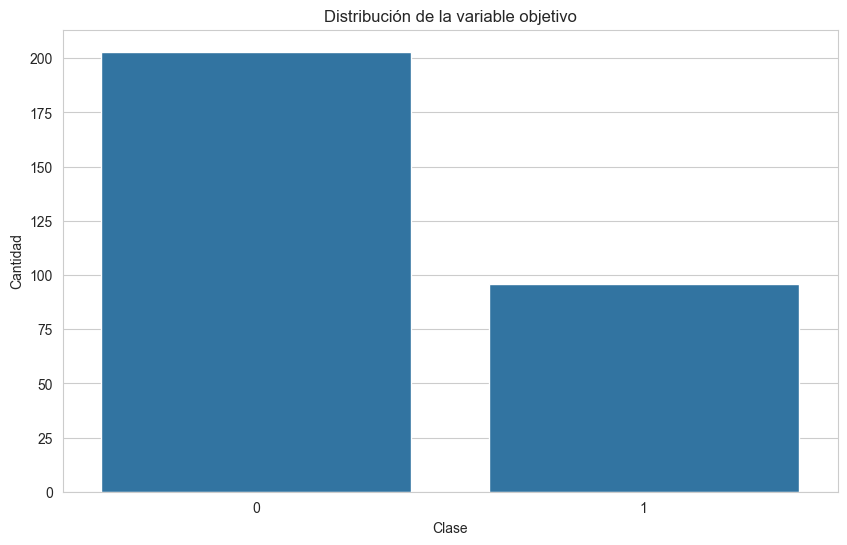

In [274]:
#Vemos la distribucion de la target. Está muy desbalanceado, tener en cuenta esto para las metricas
sns.countplot(x='muerte', data=df)
plt.title("Distribución de la variable objetivo")
plt.xlabel("Clase")
plt.ylabel("Cantidad")
plt.show()

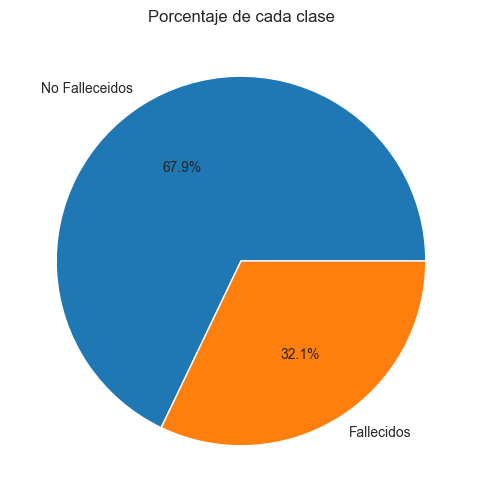

In [275]:
df["muerte"].value_counts().plot.pie(autopct='%1.1f%%', labels=["No Falleceidos", "Fallecidos"])
plt.title("Porcentaje de cada clase")
plt.ylabel("")
plt.show()

In [276]:
df.describe()

,edad,anemia,cpk,diabetes,fraccion_eyeccion,presion_alta,plaquetas,creatinina_serica,sodio_serico,sexo,fumador,dias_seguimiento,muerte
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


C:\Users\Usuario\AppData\Local\Temp\ipykernel_36500\3347895646.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='muerte', y=col, data=df, ax=axes[i], palette='Set2')
C:\Users\Usuario\AppData\Local\Temp\ipykernel_36500\3347895646.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='muerte', y=col, data=df, ax=axes[i], palette='Set2')
C:\Users\Usuario\AppData\Local\Temp\ipykernel_36500\3347895646.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='muerte', y=col, data=df, ax=axes[i], palette='Set2')
C:\Users\Usuario\AppData\Local\

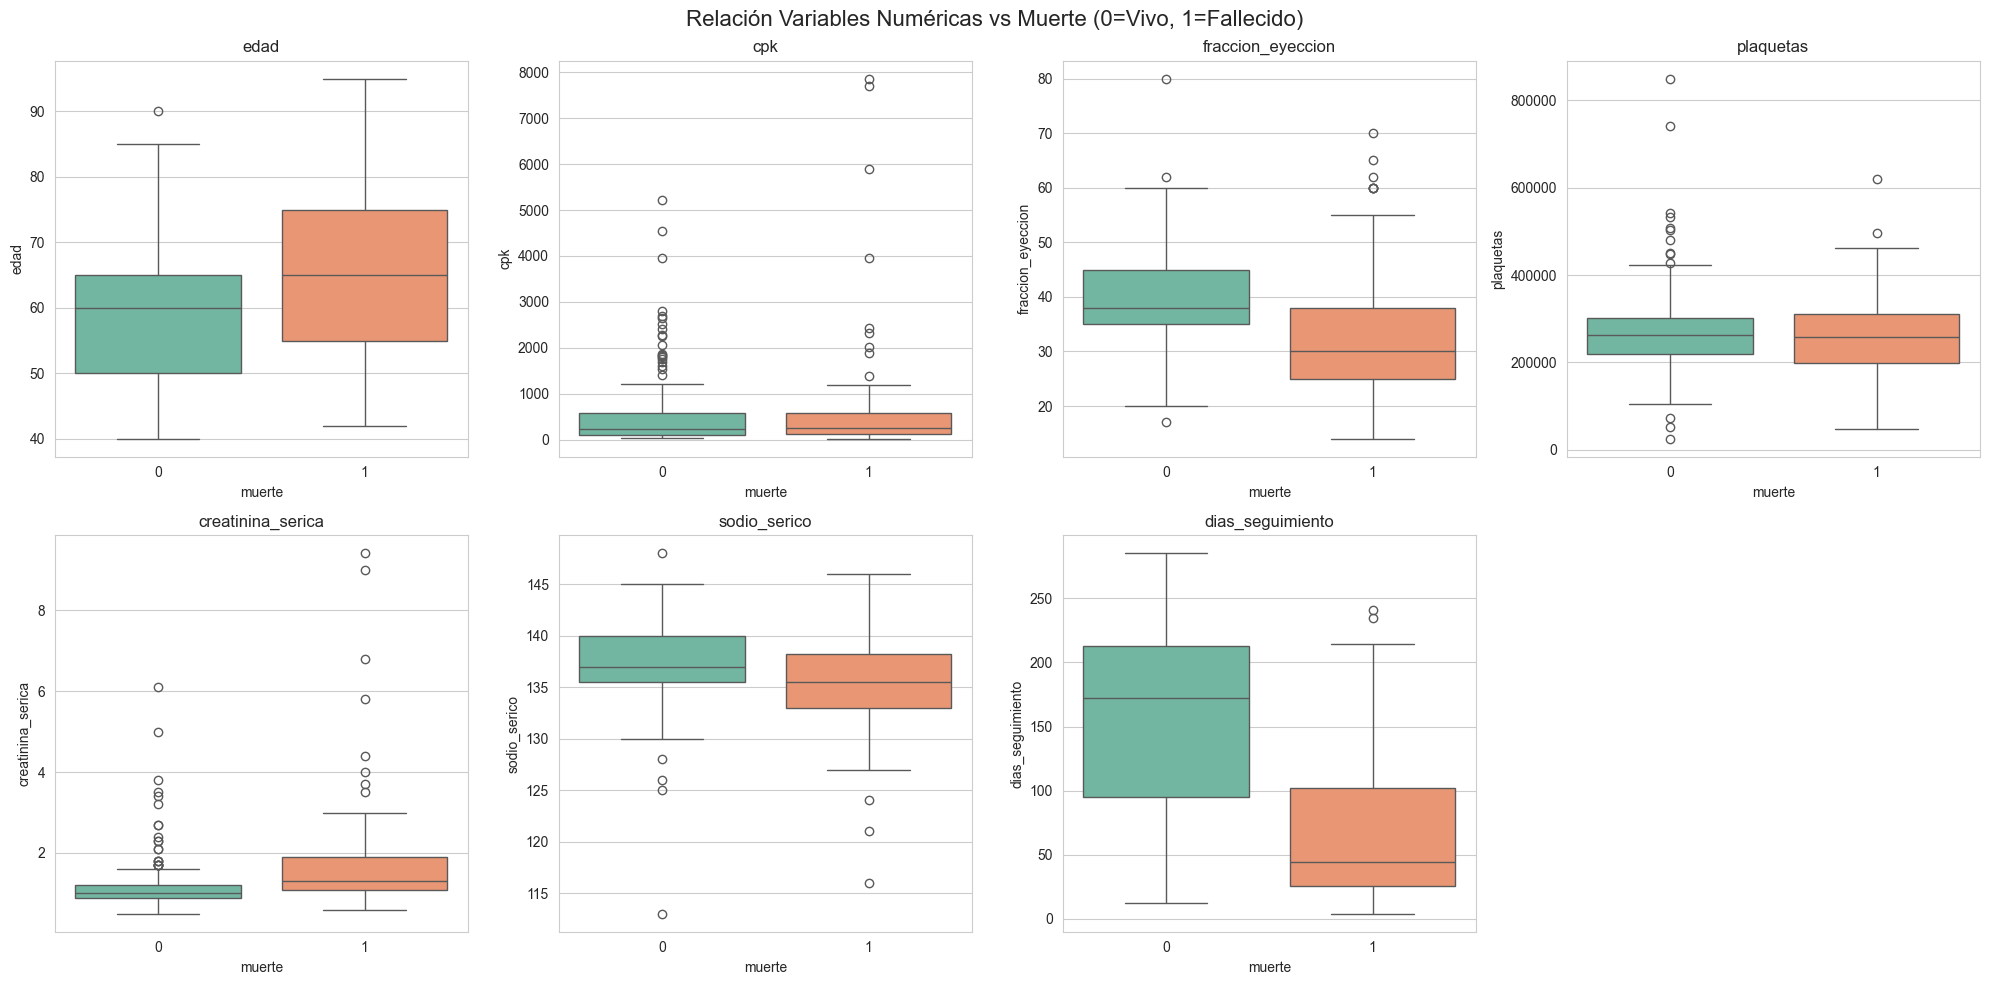

In [277]:
# 1. Separamos las columnas numéricas
num_cols = ['edad', 'cpk', 'fraccion_eyeccion', 'plaquetas', 'creatinina_serica', 'sodio_serico', 'dias_seguimiento']

# 2. Configuración del gráfico (Grid de 2 filas x 4 columnas)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Relación Variables Numéricas vs Muerte (0=Vivo, 1=Fallecido)', fontsize=16)

# Aplanamos el array de ejes para iterar fácil
axes = axes.flatten()

# 3. Bucle para graficar cada una
for i, col in enumerate(num_cols):
    sns.boxplot(x='muerte', y=col, data=df, ax=axes[i], palette='Set2')
    axes[i].set_title(col)

# Borramos el último gráfico vacío (porque son 7 variables y hay 8 espacios)
fig.delaxes(axes[7])

plt.tight_layout()
plt.show()

Se observa que las variables mas importantes para poder predecir fallecimientos son.
Los dias de seguimiento, claramente a menos seguimiento medico el reisgo de muerte aumenta.
La edad, a mayor edad el riesgo de muerte por insuficiencia cardiaca aumenta.
La creatinina, se ve claramente a que alta creatinina puede llevar a una muerte por insuficiencia cardiaca, ya que posiblemente una alta concentracion de creatinina pueda generar un daño renal.


In [278]:
# Lista de tus variables binarias
binarias = ['anemia', 'diabetes', 'presion_alta', 'sexo', 'fumador']

print("--- ANÁLISIS DE RIESGO POR VARIABLE BINARIA ---")
print("(Qué porcentaje de cada grupo falleció)\n")

for var in binarias:
    # Creamos la tabla cruzada
    # normalize='index' nos da los porcentajes por fila
    crosstab = pd.crosstab(df[var], df['muerte'], normalize='index') * 100
    
    # Imprimimos el resultado
    print(f"Variable: {var.upper()}")
    print(f" - Si es 0 (NO tiene): Falleció el {crosstab.loc[0, 1]:.1f}%")
    print(f" - Si es 1 (SÍ tiene): Falleció el {crosstab.loc[1, 1]:.1f}%")
    
    # Calculamos la diferencia
    diff = crosstab.loc[1, 1] - crosstab.loc[0, 1]
    if abs(diff) < 5:
        print("   -> CONCLUSIÓN: No influye mucho (Diferencia pequeña)")
    else:
        print(f"   -> CONCLUSIÓN: ¡Diferencia relevante de {diff:.1f} puntos!")
    print("-" * 40)

--- ANÁLISIS DE RIESGO POR VARIABLE BINARIA ---
(Qué porcentaje de cada grupo falleció)

Variable: ANEMIA
 - Si es 0 (NO tiene): Falleció el 29.4%
 - Si es 1 (SÍ tiene): Falleció el 35.7%
   -> CONCLUSIÓN: ¡Diferencia relevante de 6.2 puntos!
----------------------------------------
Variable: DIABETES
 - Si es 0 (NO tiene): Falleció el 32.2%
 - Si es 1 (SÍ tiene): Falleció el 32.0%
   -> CONCLUSIÓN: No influye mucho (Diferencia pequeña)
----------------------------------------
Variable: PRESION_ALTA
 - Si es 0 (NO tiene): Falleció el 29.4%
 - Si es 1 (SÍ tiene): Falleció el 37.1%
   -> CONCLUSIÓN: ¡Diferencia relevante de 7.8 puntos!
----------------------------------------
Variable: SEXO
 - Si es 0 (NO tiene): Falleció el 32.4%
 - Si es 1 (SÍ tiene): Falleció el 32.0%
   -> CONCLUSIÓN: No influye mucho (Diferencia pequeña)
----------------------------------------
Variable: FUMADOR
 - Si es 0 (NO tiene): Falleció el 32.5%
 - Si es 1 (SÍ tiene): Falleció el 31.2%
   -> CONCLUSIÓN: No in

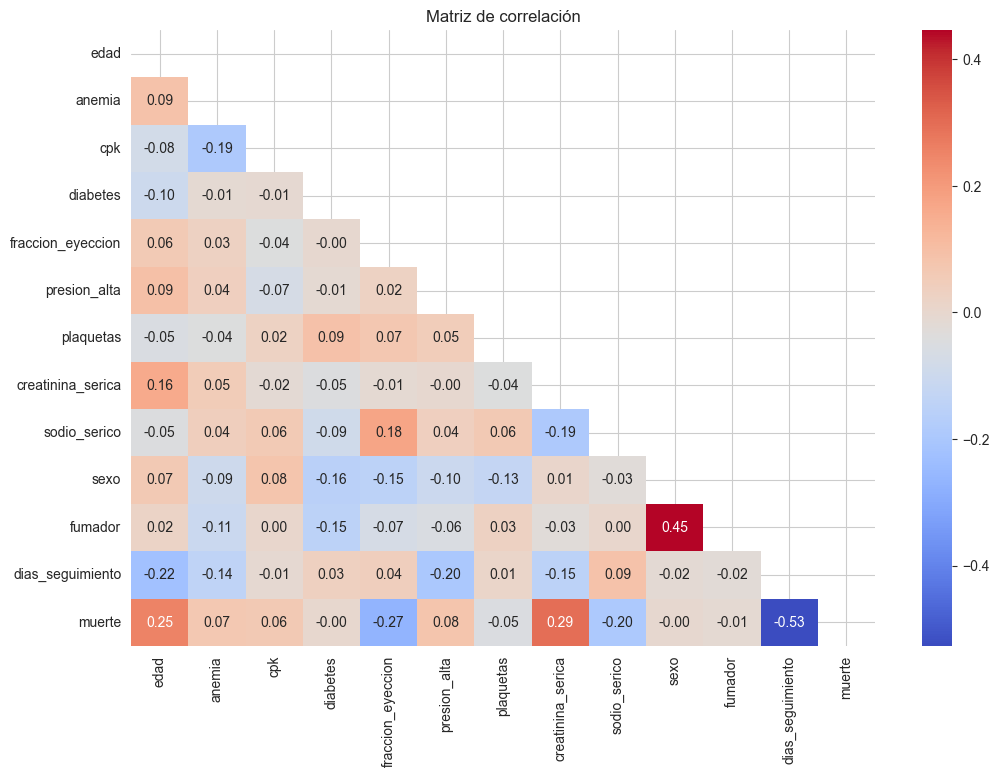

In [279]:
import numpy as np 

# Solo columnas numéricas (incluyendo type_num)
corr = df.corr()

#Mascara para graficar la mitad
np.ones_like(corr, dtype=bool)
mask = np.triu(np.ones_like(corr, dtype=bool))

# Mapa de calor
plt.figure(figsize=(12,8))
sns.heatmap(corr,
            mask=mask,
            annot=True,
            cmap='coolwarm',
            fmt=".2f")
plt.title("Matriz de correlación")
plt.show()

Analizando la matriz de coorrelacion vemos nuevamente que las variables que mas relacionadas a la muerte son la edad avanzada, la alta concentracion de creatinina y el menor seguimiento medico de la enfermedad.
De esto vemos que la variable sexo y fumador tienen una alta coorrelacion entre ellas por lo tanto para el entrenamiento del modelo podemos disernir de una o las 2 ya que ninguna tiene correlacion con la target que buscamos.

In [280]:
x = df.drop(['sexo','muerte','diabetes'], axis = 1).copy()
#Sacamos las variables que no aportan informacion para la clasificacion y sacamos la variable muerte ya que es nuestra target


In [281]:
y = df['muerte'].copy()
y.value_counts()

muerte
0    203
1     96
Name: count, dtype: int64

In [282]:

# Divide el dataset: 80 % para entrenamiento y 20 % para prueba
# - test_size=0.2   → 20 % de las filas se reservan para evaluar el modelo
# - random_state=42 → fija la “semilla” para que el split sea siempre igual (reproducibilidad)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30,  random_state=42, stratify=y)

print(x_train.shape)  # ← dimensiones de las features de entrenamiento
print(x_test.shape)   # ← dimensiones de las features de prueba
print(y_train.shape)  # ← longitud del vector objetivo de entrenamiento
print(y_test.shape)   # ← longitud del vector objetivo de prueba

(209, 10)
(90, 10)
(209,)
(90,)


In [283]:
#Seleccionamos las columnas que son continuas y descartamos las binarias para escalar

# 1. Selecciona TODAS las columnas numéricas 
all_numeric = x_train.select_dtypes(include=np.number).columns

# 2. Filtra: Se Queda solo con las que tienen más de 2 valores únicos
cols_a_escalar = [col for col in all_numeric if x_train[col].nunique() > 2]

print("✅ Columnas que se van a escalar:", cols_a_escalar)
cols_a_escalar


✅ Columnas que se van a escalar: ['edad', 'cpk', 'fraccion_eyeccion', 'plaquetas', 'creatinina_serica', 'sodio_serico', 'dias_seguimiento']


['edad',
 'cpk',
 'fraccion_eyeccion',
 'plaquetas',
 'creatinina_serica',
 'sodio_serico',
 'dias_seguimiento']

In [284]:
#Escalado de x_train y x_test
scaler = RobustScaler()
x_train_std = scaler.fit_transform(x_train[cols_a_escalar]).copy()
x_test_std = scaler.transform(x_test[cols_a_escalar]).copy()

x_train_std = pd.DataFrame(x_train_std, columns=cols_a_escalar, index=x_train.index)
x_test_std = pd.DataFrame(x_test_std, columns=cols_a_escalar, index=x_test.index)

x_train_std


,edad,cpk,fraccion_eyeccion,plaquetas,creatinina_serica,sodio_serico,dias_seguimiento
186,-0.555556,0.713666,0.800000,-1.199544,-1.25,-0.6,0.480315
258,-0.833333,-0.405640,-0.866667,-0.329979,-0.75,-0.4,0.937008
104,0.000000,-0.433839,0.800000,0.246108,3.00,1.2,-0.188976
161,-0.833333,-0.266811,-0.200000,-0.971283,-0.75,0.4,0.078740
263,0.444444,-0.208243,1.466667,-0.601718,-0.25,0.6,0.992126
...,...,...,...,...,...,...,...
134,1.166667,9.299349,-0.200000,-0.351718,0.20,0.0,-0.031496
229,0.666667,-0.091106,-0.866667,0.115674,0.25,-0.6,0.755906
74,0.500000,0.713666,-1.200000,0.028717,0.25,-0.6,-0.299213
177,-0.611111,-0.399132,0.800000,-1.427805,-0.25,0.6,0.283465


In [285]:
# Unimos las numéricas escaladas con las binarias originales
# Usamos el índice para asegurar que los pacientes coincidan

# Para Train
x_train_final = pd.concat([
    x_train_std, 
    x_train.drop(cols_a_escalar, axis=1) # Las binarias que dejamos fuera
], axis=1)

#Para Test
x_test_final = pd.concat([
   x_test_std, 
    x_test.drop(cols_a_escalar, axis=1)
], axis=1)

# Verificamos
x_train_final.head()

,edad,cpk,fraccion_eyeccion,plaquetas,creatinina_serica,sodio_serico,dias_seguimiento,anemia,presion_alta,fumador
186,-0.555556,0.713666,0.800000,-1.199544,-1.25,-0.6,0.480315,0,0,0
258,-0.833333,-0.405640,-0.866667,-0.329979,-0.75,-0.4,0.937008,1,0,0
104,0.000000,-0.433839,0.800000,0.246108,3.00,1.2,-0.188976,0,1,0
161,-0.833333,-0.266811,-0.200000,-0.971283,-0.75,0.4,0.078740,1,0,1
263,0.444444,-0.208243,1.466667,-0.601718,-0.25,0.6,0.992126,1,0,0


# Clasificacion

## Decision Tree

In [286]:
dt = DecisionTreeClassifier(random_state=42) #Instancio el modelo

In [287]:
# Definir la grilla de hiperparámetros
param_grid = {
    "max_depth": [3, 5, 7, 10, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10],
    "max_features": [None, "sqrt", "log2"]
}
# GridSearchCV
grid_search_tree = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=2
)

In [288]:
import time

#Entrenamiento
start_time_dtree = time.time() # registramos tiempo de inicio
grid_search_tree.fit(x_train_final, y_train)# entrenamos
end_time_dtree = time.time() # registramos tiempo de fin
dtree_train_time = end_time_dtree - start_time_dtree  # calculamos tiempo total
print(f'Entrenamiento completado en: {dtree_train_time} segundos.')

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Entrenamiento completado en: 17.424943447113037 segundos.


In [289]:
# Mejor modelo
print("Mejores hiperparámetros:", grid_search_tree.best_params_)
print("Mejor accuracy (validación):", grid_search_tree.best_score_)

Mejores hiperparámetros: {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
Mejor accuracy (validación): 0.6867910052910053


In [290]:
# Evaluación en test
best_model_tree = grid_search_tree.best_estimator_
y_pred_tree = best_model_tree.predict(x_test_final) #Prediccion

acc_tree = accuracy_score(y_test, y_pred_tree)
print("Accuracy en test:", accuracy_score(y_test, y_pred_tree))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred_tree))

Accuracy en test: 0.7888888888888889

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.88      0.80      0.84        61
           1       0.65      0.76      0.70        29

    accuracy                           0.79        90
   macro avg       0.76      0.78      0.77        90
weighted avg       0.80      0.79      0.79        90



El Problema Crítico: El Recall de la Clase 1 (0.76) 
Esta es la métrica más importante de todo el reporte y es donde el modelo está fallando.

¿Qué significa? De todos los pacientes que realmente fallecieron, el modelo solo detectó al 76%.

En la vida real: Si entran 100 pacientes graves a tu guardia, el modelo detecta a 76 y manda a su casa a 24 diciéndoles "estás sano", y esos 24 fallecen.

Conclusión: El modelo tiene demasiados Falsos Negativos. Es muy "tímido" para predecir la muerte.

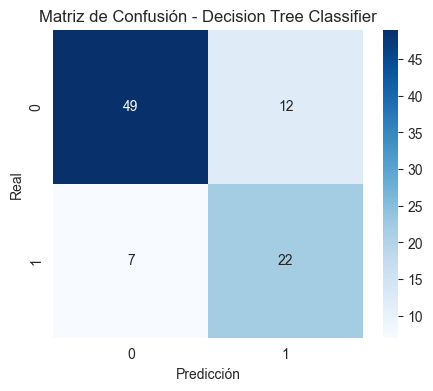

In [291]:
# Matriz de confusión
cm_tree = confusion_matrix(y_test, y_pred_tree, labels=best_model_tree.classes_)

# Versión con seaborn (heatmap)
plt.figure(figsize=(5,4))
sns.heatmap(cm_tree, annot=True, fmt="d", cmap="Blues",
            xticklabels=best_model_tree.classes_,
            yticklabels=best_model_tree.classes_)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Decision Tree Classifier")
plt.show()

## Random Forest

In [292]:
# Valores de n_estimators a probar (número de árboles en el Random Forest)
n_estimators_range = [10, 50, 100, 200, 300]

# Listas para guardar precisión y tiempo de entrenamiento por cada modelo
accuracies_n_estimators = []
training_times_n_estimators = []

In [293]:

# 1. Definimos el modelo base (importante agregar class_weight='balanced' para tu caso médico)
rf = RandomForestClassifier( class_weight='balanced',random_state=42)

# 2. Definimos la Grilla de Hiperparámetros
param_grid_rf = {
    "n_estimators": [50, 100, 200],

    "max_depth": [5, 10, 15, None],
    
    "min_samples_split": [2, 5, 10],
    
    "min_samples_leaf": [1, 2, 4],
    
    "max_features": ["sqrt", "log2"]
}

# 3. Configuramos el GridSearchCV
# IMPORTANTE: Cambiamos 'scoring' a 'recall' o 'f1' porque te importa detectar la mortalidad
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,               # Validación cruzada de 5 pliegues
    scoring="f1",       # Optimizamos F1-Score (balance entre Recall y Precision)
    n_jobs=-1,          # Usar todos los procesadores
    verbose=2
)

# 4. Entrenar (Esto puede tardar unos minutos porque prueba muchas combinaciones)
#Entrenamiento
start_time_simple_rf = time.time()
grid_search_rf.fit(x_train_final, y_train)
end_time_simple_rf = time.time()
simple_rf_train_time = end_time_simple_rf - start_time_simple_rf

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


In [294]:
# Mejor modelo
print("Mejores hiperparámetros:", grid_search_rf.best_params_)
print("Mejor accuracy (validación):", grid_search_rf.best_score_)
rf_best = grid_search_rf.best_estimator_

Mejores hiperparámetros: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Mejor accuracy (validación): 0.781058201058201


In [295]:

#Prediccion
rf_pred = rf_best.predict(x_test_final)

#Evaluacion
acc_rf = accuracy_score(y_test, rf_pred)
print("Accuracy en test:", accuracy_score(y_test, rf_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, rf_pred))

Accuracy en test: 0.8222222222222222

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87        61
           1       0.76      0.66      0.70        29

    accuracy                           0.82        90
   macro avg       0.80      0.78      0.79        90
weighted avg       0.82      0.82      0.82        90



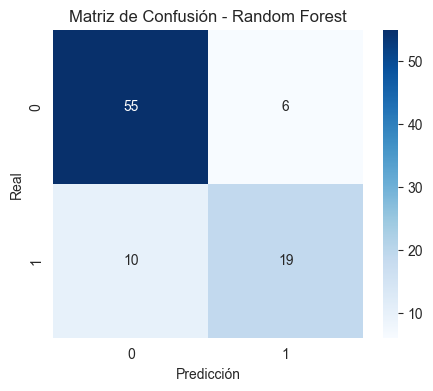

In [296]:
# Matriz de confusión
cm_rf_df_filtered = confusion_matrix(y_test, rf_pred, labels=rf_best.classes_)

# Versión con seaborn (heatmap)
plt.figure(figsize=(5,4))
sns.heatmap(cm_rf_df_filtered, annot=True, fmt="d", cmap="Blues",
            xticklabels=rf_best.classes_,
            yticklabels=rf_best.classes_)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Random Forest")
plt.show()


## XGBoost

In [297]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# 1. Definimos el modelo base
# eval_metric='logloss' elimina advertencias molestas
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

# 2. Definimos la Grilla
param_grid_xgb = {

    'n_estimators': [50, 100, 200],

    'learning_rate': [0.01, 0.1, 0.2],
    
    'max_depth': [3, 5, 7],
    
    # EL TRUCO PARA DESBALANCEO (Reemplaza a class_weight='balanced')
    # Controla cuánto peso se le da a la clase minoritaria (1).
    # Como tienes aprox 2 sanos por cada 1 fallecido, probamos valores cercanos a 2.
    'scale_pos_weight': [1, 2, 3] 
}

# 3. Configuramos el GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    cv=5,
    scoring='f1',  # Buscamos el mejor equilibrio Recall/Precision
    n_jobs=-1,
    verbose=2
)

# 4. Entrenar (Esto usa x_train_final que tiene todo unido)
start_time = time.time()
grid_search_xgb.fit(x_train_final, y_train)
end_time = time.time()
train_time_xgb_initial = end_time - start_time

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [298]:
# Mejor modelo
print("Mejores hiperparámetros:", grid_search_xgb.best_params_)
print("Mejor accuracy (validación):", grid_search_xgb.best_score_)
xgb_best = grid_search_xgb.best_estimator_

Mejores hiperparámetros: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 2}
Mejor accuracy (validación): 0.7658038258038257


In [299]:
y_train_pred_xgb_initial = xgb_best.predict(x_train_final)
y_test_pred_xgb_initial = xgb_best.predict(x_test_final)

print(f"Tiempo de entrenamiento (XGBoost inicial): {train_time_xgb_initial:.4f} segundos")
print("\nReporte de Clasificación (XGBoost Inicial - Test):")
print(classification_report(y_test, y_test_pred_xgb_initial))
acc_xgb = accuracy_score(y_test, y_test_pred_xgb_initial)

Tiempo de entrenamiento (XGBoost inicial): 13.1291 segundos

Reporte de Clasificación (XGBoost Inicial - Test):
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        61
           1       0.77      0.69      0.73        29

    accuracy                           0.83        90
   macro avg       0.81      0.80      0.80        90
weighted avg       0.83      0.83      0.83        90



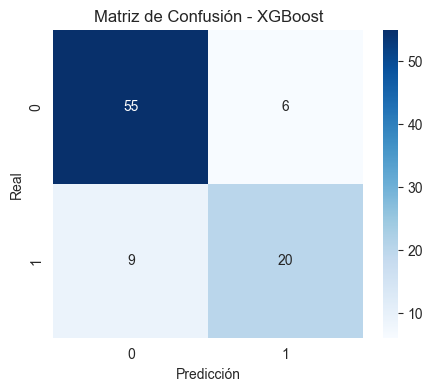

In [300]:
# Generamos la matriz de confusión usando las etiquetas codificadas
cm_gxb = confusion_matrix(y_test, y_test_pred_xgb_initial, labels=[0,1])

# Graficamos
plt.figure(figsize=(5,4))
sns.heatmap(cm_gxb, annot=True, fmt="d", cmap="Blues",
            )
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - XGBoost")
plt.show()

## MLP 

In [301]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# 1. Definir el modelo base
# max_iter=1000 es vital para asegurar que la red converja (termine de aprender)
mlp = MLPClassifier(random_state=42, max_iter=1000)

# 2. Definir la Grilla de Hiperparámetros
param_grid_mlp = {
    # Arquitectura: Cuántas neuronas y capas.
    # (50,) = 1 capa de 50 neuronas. (50, 50) = 2 capas de 50.
    # Como tienes pocos datos (299 filas), arquitecturas pequeñas son mejores para no memorizar.
    'hidden_layer_sizes': [(30,), (50,), (100,), (30, 30)],

    # Función de activación: Cómo decide la neurona disparar.
    'activation': ['relu', 'tanh'],

    # Optimizador: Adam es el estándar, sgd a veces generaliza mejor.
    'solver': ['adam', 'sgd'],

    # Regularización L2 (Alpha): CRÍTICO para datos pequeños.
    # Valores más altos (0.05, 0.1) castigan más al modelo para evitar overfitting.
    'alpha': [0.0001, 0.001, 0.01, 0.05],

    # Velocidad de aprendizaje inicial
    'learning_rate_init': [0.001, 0.01]
}

# 3. Configurar el GridSearch
grid_search_mlp = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid_mlp,
    cv=5,
    scoring='f1',  # Optimizamos F1 para balancear Precision y Recall
    n_jobs=-1,
    verbose=1
)

# 4. Entrenar
print("🧠 Entrenando MLPClassifier (esto puede tardar un poco)...")

# IMPORTANTE: Usar x_train_final (escalado) es OBLIGATORIO para redes neuronales
start_time = time.time()
grid_search_mlp.fit(x_train_final, y_train)
end_time = time.time()
train_time_mlp = end_time - start_time



# 5. Mejores parámetros
print(f"Mejor configuración: {grid_search_mlp.best_params_}")

🧠 Entrenando MLPClassifier (esto puede tardar un poco)...
Fitting 5 folds for each of 128 candidates, totalling 640 fits
Mejor configuración: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (30, 30), 'learning_rate_init': 0.01, 'solver': 'adam'}


--- Reporte del MLPClassifier ---
              precision    recall  f1-score   support

           0       0.84      0.87      0.85        61
           1       0.70      0.66      0.68        29

    accuracy                           0.80        90
   macro avg       0.77      0.76      0.77        90
weighted avg       0.80      0.80      0.80        90



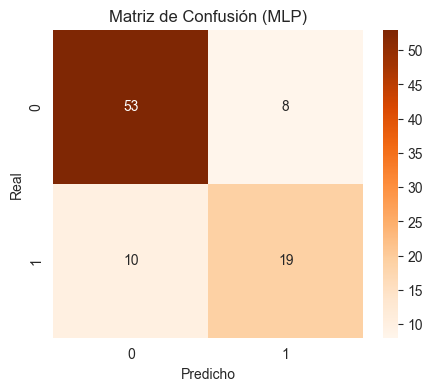

In [302]:

# 1. Obtener el mejor modelo
best_mlp = grid_search_mlp.best_estimator_

# 2. Predecir
y_pred_mlp = best_mlp.predict(x_test_final)

# 3. Reporte
print("--- Reporte del MLPClassifier ---")
print(classification_report(y_test, y_pred_mlp))
acc_mlp = accuracy_score(y_test, y_pred_mlp)

# 4. Matriz de Confusión
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_mlp), annot=True, fmt='d', cmap='Oranges')
plt.title('Matriz de Confusión (MLP)')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

# Comparacion de tiempos y precision

C:\Users\Usuario\AppData\Local\Temp\ipykernel_36500\2480951642.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='viridis')


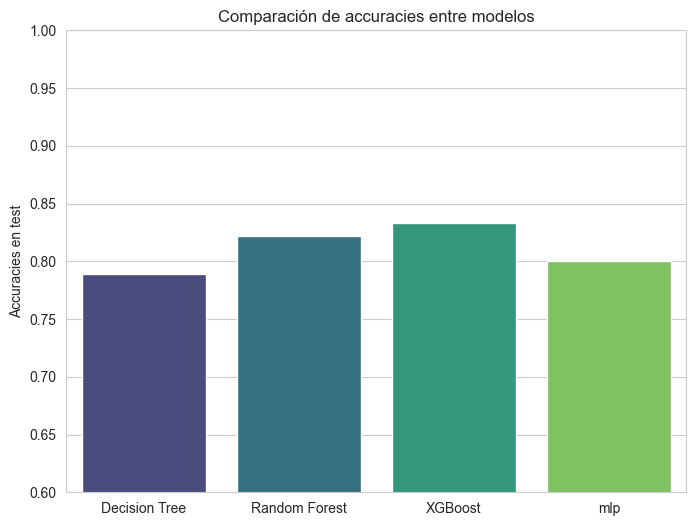

In [303]:
# Gráfico de comparación de precisión
models = ['Decision Tree','Random Forest', 'XGBoost','mlp']
accuracies = [acc_tree,  acc_rf, acc_xgb, acc_mlp]

plt.figure(figsize=(8, 6))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.title('Comparación de accuracies entre modelos')
plt.ylabel('Accuracies en test')
plt.ylim(0.6, 1.0)
plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_36500\954589039.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=recalls, palette='viridis')


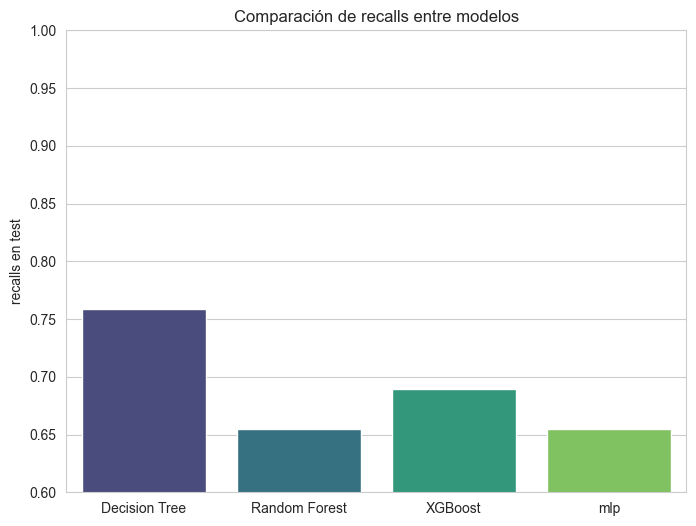

In [304]:
#Grafico de comparaion de recall
r_tree = recall_score(y_test, y_pred_tree)
r_rf = recall_score(y_test, rf_pred)
r_xgb = recall_score(y_test, y_test_pred_xgb_initial)
r_mlp = recall_score(y_test, y_pred_mlp)

models = ['Decision Tree','Random Forest', 'XGBoost','mlp']
recalls = [r_tree,  r_rf, r_xgb, r_mlp]

plt.figure(figsize=(8, 6))
sns.barplot(x=models, y=recalls, palette='viridis')
plt.title('Comparación de recalls entre modelos')
plt.ylabel('recalls en test')
plt.ylim(0.6, 1.0)
plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_36500\1032482275.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=training_times_labels, y=training_times_values, palette='plasma')


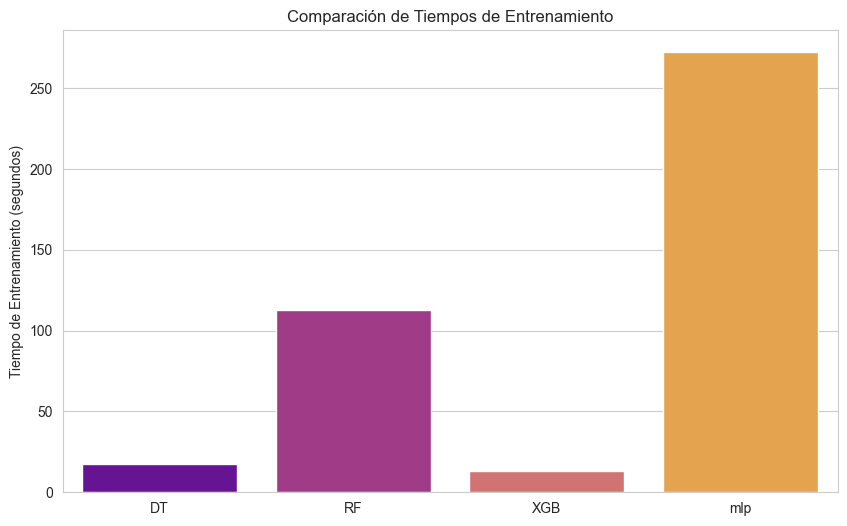

In [305]:
# Gráfico de comparación de tiempos
training_times_labels = ['DT', 'RF', 'XGB', 'mlp']
training_times_values = [dtree_train_time,  simple_rf_train_time, train_time_xgb_initial,train_time_mlp]

plt.figure(figsize=(10, 6))
sns.barplot(x=training_times_labels, y=training_times_values, palette='plasma')
plt.title('Comparación de Tiempos de Entrenamiento')
plt.ylabel('Tiempo de Entrenamiento (segundos)')
plt.show()

# Conclusiones

Tras realizar un análisis exhaustivo comparando cuatro arquitecturas de aprendizaje supervisado (**Árbol de Decisión, Random Forest, XGBoost y Perceptrón Multicapa - MLP**) sobre el dataset de Insuficiencia Cardíaca, presentamos las siguientes conclusiones:

### 1. Selección del Modelo Ganador: Árbol de Decisión 🌳
Se ha seleccionado el **Árbol de Decisión** como el modelo más apto para esta problemática específica.

* **Justificación Clínica (Recall vs. Accuracy):** Aunque otros modelos (como Random Forest) obtuvieron un *Accuracy* global ligeramente superior, el Árbol de Decisión logró el **mejor desempeño en Recall (Sensibilidad) para la clase positiva (Muerte), alcanzando un 76%**.
* **Impacto de los Falsos Negativos:** En el contexto médico de urgencias, el costo de un **Falso Negativo** (predecir que un paciente de alto riesgo está "sano" y no intervenir) es la pérdida de una vida. Por el contrario, un Falso Positivo (una falsa alarma) solo implica mayor vigilancia médica. Por lo tanto, priorizamos maximizar la detección de casos positivos sobre la precisión global.

### 2. Comparativa de Rendimiento y Eficiencia ⚡
* **Árbol vs. XGBoost:** Ambos modelos demostraron ser los más **eficientes en tiempos de entrenamiento**, convergiendo rápidamente con bajo costo computacional. Sin embargo, se observó un *trade-off* claro:
    * **XGBoost** dominó en **Precisión** (menos falsas alarmas), siendo un modelo más "seguro" pero conservador.
    * **Árbol de Decisión** dominó en **Recall**, siendo más agresivo en la detección de riesgo, lo cual se alinea mejor con nuestro objetivo clínico de *screening*.
* **Desempeño del MLP:** La Red Neuronal no logró superar a los modelos basados en árboles, sufriendo dificultades para generalizar debido al pequeño volumen de datos.

### 3. Limitaciones y Trabajo Futuro ⚠️
Es imperativo aclarar que, si bien el 76% de Recall es el mejor resultado obtenido, **estas métricas no son aún óptimas para un despliegue clínico en producción**.

* **El Problema del "Small Data":** La principal limitante es el tamaño del dataset ($N=299$). La escasez de muestras impide que los modelos aprendan patrones sutiles sin caer en sobreajuste o inestabilidad.
* **Recomendación:** Para mejorar la robustez del sistema y habilitar el uso efectivo de modelos más complejos (como Deep Learning), la prioridad absoluta debe ser la **recolección de más datos clínicos**. Con un dataset más grande, es probable que arquitecturas como XGBoost o MLP superen al Árbol simple al reducir la varianza.